# Introdunction

In this tutorial:
- a book on llm is split into chunks
- for each chunk a work embedding is created. (in parallel)
- the embeddings are stored in a chroma db
- we create a funcion that given a question extracts context from the chroma db based on similarity
- the question and context are provided to openai chat.completions for a final answer
- the application is deployed in a gradio app

## ToDo
- create this in a nice project structure (ml-project-template repo)
- containerize the application
- run it in the cloud
    

In [2]:
import sys
import os

# Use current working directory and go one level up
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

# Now you can import your config
from config import api_key

# allow chromadb to reste the database
import os
os.environ["ALLOW_RESET"] = "TRUE"

**remark** - I copied some text but actually use openai in this notebook

Why Use DeepSeek-R1 With RAG?

DeepSeek-R1 is an ideal fit for RAG-based systems due to its optimized performance, advanced vector search capabilities, and flexibility across different environments, from local setups to scalable deployments. Here are some reasons why it’s effective:

1. High-performance retrieval: DeepSeek-R1 handles large document collections with low latency.
2. Fine-grained relevance ranking: It ensures accurate retrieval of passages by computing semantic similarity.
3. Cost and privacy benefits: You can run DeepSeek-R1 locally to avoid API fees and keep sensitive data secure.
4. Easy integration: It easily integrates with vector databases like Chroma.
5. Offline capabilities: With DeepSeek-R1 you can build retrieval systems that work even without internet access once the model is downloaded.

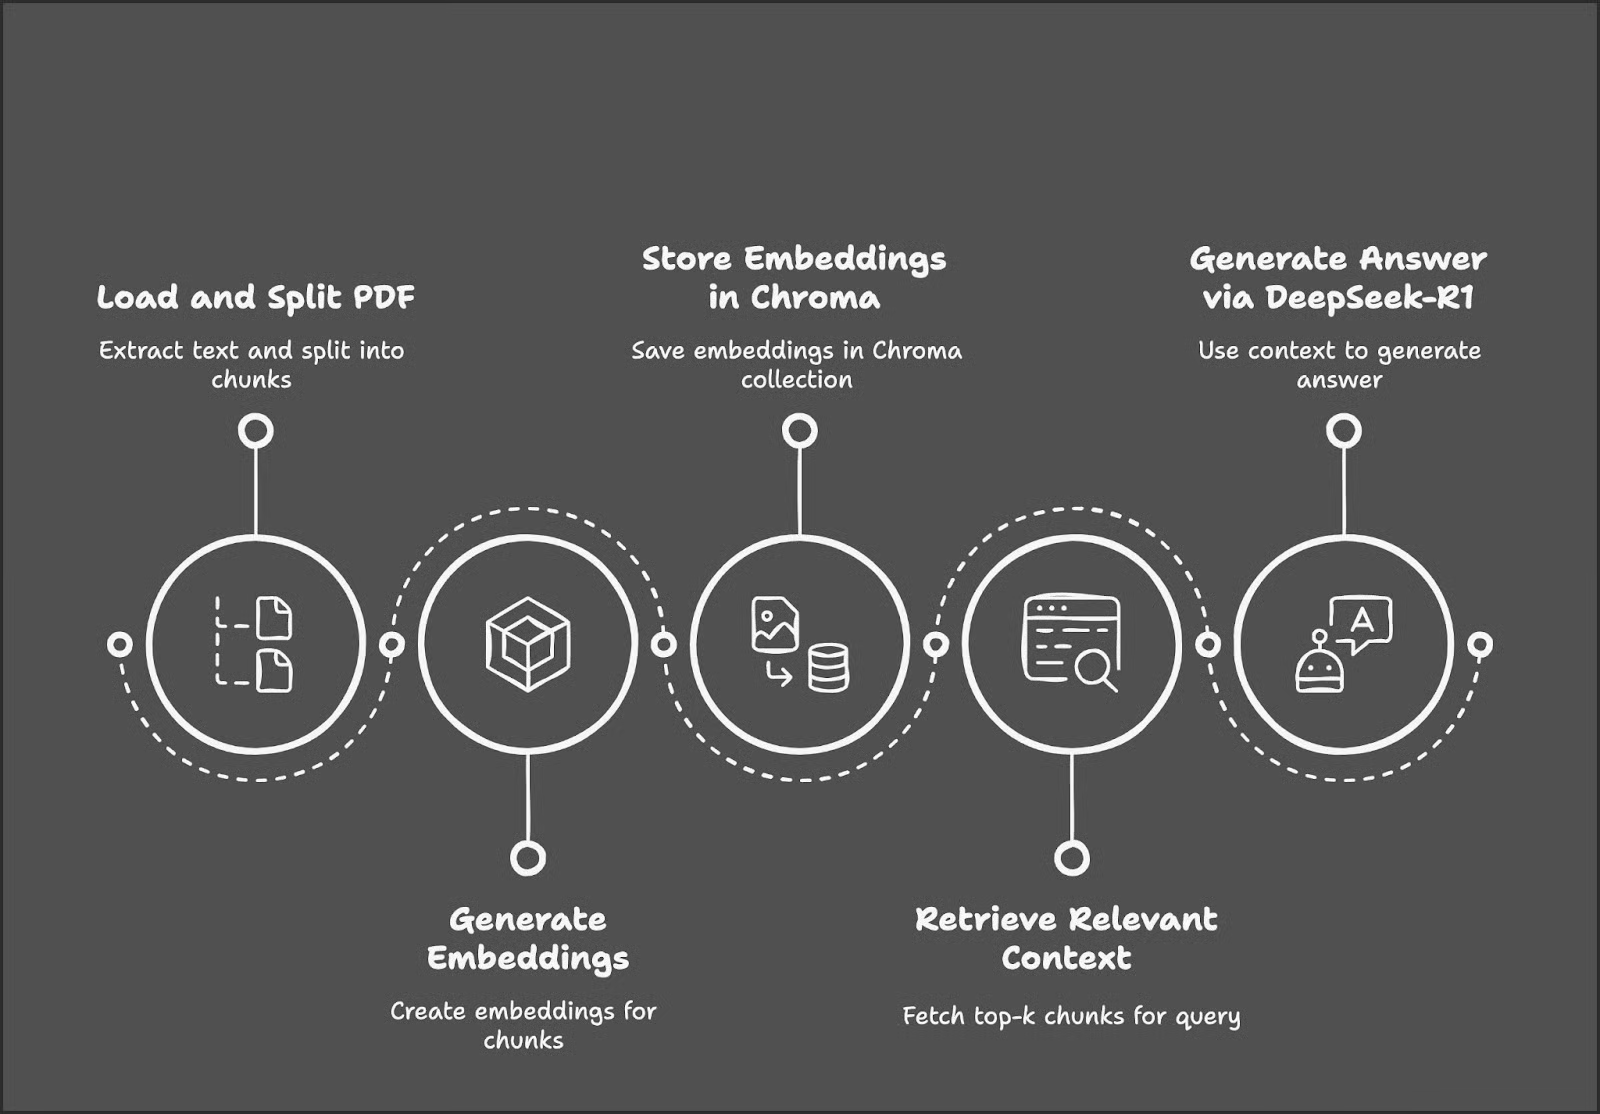

The process begins with loading and splitting a PDF into text chunks, followed by generating embeddings for those chunks. These embeddings are stored in a Chroma database for efficient retrieval. When a user submits a query, the system retrieves the most relevant text chunks and uses DmeepSeek-R1 to generate an answer based on the retrieved context.

## Chapter 1 - Three approaches to create embeddings

### Section 1.1. - Text embeddings using openai

Below it is shown how we can create embeddings using the openai API.

In [ ]:
import openai

openai_client = openai.OpenAI(api_key=api_key)

# example texts
texts = ["hello world", "LangChain is cool", "This is an embedding example"]

response = openai_client.embeddings.create(
    model="text-embedding-3-small",
    input= texts
)

len(response.data)

### Section 1.2 - Text embeddings using langchain

This sections shows how we can use OpenAI embeddings using langchain

In [ ]:
from langchain_openai import OpenAIEmbeddings

# create an embedding object
embedding_model = OpenAIEmbeddings(api_key=api_key, model="text-embedding-3-small")

# example texts
texts = ["hello world", "LangChain is cool", "This is an embedding example"]

# Get embeddings
embeddings = embedding_model.embed_documents(texts)

# print results
for i, emb in enumerate(embeddings):
    print(i, len(emb))

### Section 1.3a - Text embeddings using crhoma db

In [ ]:
import chromadb
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# create a client
client = chromadb.PersistentClient(path="db/")

# create a 'table' in chromadb
collection = client.get_or_create_collection(name="test")

print(client.list_collections())

openai_ef = OpenAIEmbeddingFunction(
        api_key=api_key,
        model_name="text-embedding-3-small")

# example texts
texts = ["hello world", "LangChain is cool", "This is an embedding example"]

# create embeddings and print the first elements of the first embeddings
embeddings = openai_ef(texts)
print(embeddings[0][:10])
print(len(embeddings[0]))

# add the embeddings to the collection
collection.add(
    embeddings = embeddings,
    documents= texts,
    metadatas = [{"source": "student info"},{"source": "club info"},{'source':'university info'}],
    ids = ["id1", "id2", "id3"]
)

# get the data from the collection
collection.get()

### Section 1.3b - Preferred approach to add embeddings using crhoma db¶

In [ ]:
client.delete_collection("test")

openai_ef = OpenAIEmbeddingFunction(
        api_key=api_key,
        model_name="text-embedding-3-small")


collection = client.get_or_create_collection(
    name="test",
    embedding_function=openai_ef)


collection.add(
    documents = texts,
    metadatas = [{"source": "student info"},{"source": "club info"},{'source':'university info'}],
    ids = ["id1", "id2", "id3"]
)

collection.get()

let's test the embedding vectors with a query

In [ ]:
results = collection.query(
    query_texts=['What is interesting?'],
    n_results=2)

results

## Create a vector embeddings table in chroma

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader

# load the document using PyMuPDFLoader
loader = PyMuPDFLoader("./Foundations_of_llms.pdf")

documents = loader.load()

### Split the Document Into Smaller Chunks

In [4]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Split the document into smaller chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = text_splitter.split_documents(documents)

for chunk in chunks:
    print(chunk.page_content)
    break

arXiv:2501.09223v1  [cs.CL]  16 Jan 2025
Foundations of
Large Language Models
Tong Xiao and Jingbo Zhu
January 17, 2025
NLP Lab, Northeastern University & NiuTrans Research


### Generate Embeddings Using OpenAI

**remark** - below it states we use deepseek but we use openai instead.

We’ll use Ollama Embeddings based on DeepSeek-R1 to generate the document embeddings. Depending on the size of the document, embedding generation can take time, so it's preferable to parallelize it for faster processing.

Note: `model="deepseek-r1`" by default considers the 7B parameter model. You can change it as required to 8B, 14B, 32B, 70B, or 671B. Replace X in the following model name with model size: `model="deepseek-r1:X"`

Create embeddings for he chunks using `langchain_openai`

In [5]:
import os
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from langchain_openai import OpenAIEmbeddings

num_cores = os.cpu_count()
print(f"Number of CPU cores: {num_cores}")
num_cores_to_use = num_cores if num_cores <10 else num_cores-3
print(f"Number CPU cores to use: {num_cores_to_use}")

# Initialize Ollama embeddings using DeepSeek-R1
embedding_function = OpenAIEmbeddings(
        api_key=api_key,
        model="text-embedding-3-small")

def generate_embedding(chunk):
    return embedding_function.embed_query(chunk.page_content)

embeddings = []

with ThreadPoolExecutor() as executor:
    embeddings = list(tqdm(executor.map(generate_embedding, chunks), total=len(chunks)))

Number of CPU cores: 12
Number CPU cores to use: 9


  0%|          | 0/821 [00:00<?, ?it/s]

No that we have the embeddings we will load them in our chroma database

In [7]:
import chromadb

client = chromadb.PersistentClient(path="db/")

#client = Client(Settings())

collection = client.get_or_create_collection(name="foundation_of_llms")

for idx, chunk in enumerate(chunks):
    collection.add(
        documents=[chunk.page_content],
        metadatas=[{'id': idx}],
        embeddings=embeddings[idx],
        ids=[str(idx)])

print(f"Number of store embedding vectors {collection.count()}")
print(f"The client has access to the following vector databases: {client.list_collections()}")

Number of store embedding vectors 821
The client has access to the following vector databases: [Collection(name=foundation_of_llms)]


In [8]:
query_emb = embedding_function.embed_query('What is a large language model?')

results = collection.query(
    query_embeddings=[query_emb],
    n_results=2)

results

{'ids': [['2', '0']],
 'embeddings': None,
 'documents': [['Preface\nLarge language models originated from natural language processing, but they have undoubtedly\nbecome one of the most revolutionary technological advancements in the ﬁeld of artiﬁcial intelli-\ngence in recent years. An important insight brought by large language models is that knowledge\nof the world and languages can be acquired through large-scale language modeling tasks, and\nin this way, we can create a universal model that handles diverse problems. This discovery has\nprofoundly impacted the research methodologies in natural language processing and many related\ndisciplines. We have shifted from training specialized systems from scratch using a large amount\nof labeled data to a new paradigm of using large-scale pre-training to obtain foundation models,\nwhich are then ﬁne-tuned, aligned, and prompted.\nThis book aims to outline the basic concepts of large language models and introduce the',
   'arXiv:2501.09223v

In [9]:
from langchain_chroma import Chroma

# Initialize retriever using OpenAI embeddings for queries
retriever = Chroma(
    collection_name="foundation_of_llms", 
    client=client, 
    embedding_function=embedding_function).as_retriever(search_kwargs={"k": 4})

def retrieve_context(question):
    # Retrieve relevant documents
    results = retriever.invoke(question)
    # Combine the retrieved content
    context = "\n\n".join([doc.page_content for doc in results])
    return context

question = "what is a large language model"
context = retrieve_context(question)

In [10]:
context

'Preface\nLarge language models originated from natural language processing, but they have undoubtedly\nbecome one of the most revolutionary technological advancements in the ﬁeld of artiﬁcial intelli-\ngence in recent years. An important insight brought by large language models is that knowledge\nof the world and languages can be acquired through large-scale language modeling tasks, and\nin this way, we can create a universal model that handles diverse problems. This discovery has\nprofoundly impacted the research methodologies in natural language processing and many related\ndisciplines. We have shifted from training specialized systems from scratch using a large amount\nof labeled data to a new paradigm of using large-scale pre-training to obtain foundation models,\nwhich are then ﬁne-tuned, aligned, and prompted.\nThis book aims to outline the basic concepts of large language models and introduce the\n\narXiv:2501.09223v1  [cs.CL]  16 Jan 2025\nFoundations of\nLarge Language Models

In [14]:
import openai

openai_client = openai.OpenAI(api_key=api_key)

def query_openai(question, context):
    formatted_prompt = {"role":"user", "content":f"Question: {question}\n\nContext: {context}"}
    
    result = openai_client.chat.completions.create(
        model="gpt-4",
        messages = [formatted_prompt],
        temperature=0)

    return result.choices[0].message.content

In [15]:
query_openai(question, context)

'A large language model is a type of artificial intelligence model that originates from natural language processing. It is designed to acquire knowledge of the world and languages through large-scale language modeling tasks. This allows the creation of a universal model that can handle diverse problems. Large language models have shifted the paradigm from training specialized systems from scratch using a large amount of labeled data to using large-scale pre-training to obtain foundation models, which are then fine-tuned, aligned, and prompted. These models are often used in tasks such as text generation, translation, and other language-related tasks.'

In [ ]:
import gradio as gr

def ask_question(question):
    # Retrieve context and generate and answer using RAG
    context = retrieve_context(question)
    answer = query_openai(question, context)
    return answer

In [ ]:
ask_question(question)

In [ ]:
interface = gr.Interface(
    fn=ask_question,
    inputs="text",
    outputs="text",
    title="RAG Chatbot: Foundations of LLMs",
    description="Ask any questions about the Foundation of LLM book. Powered by openai")

In [ ]:
interface.launch()

In [ ]:
print(retrieve_context("What is a RAG architecture"))

## Use langchain

The above code can made much more compact using langchain

In [56]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.runnables import RunnablePassthrough

question = "What is a RAG architecture"
message = "contex: {context}\nQuestion: {question}\nAnswer:"
prompt_template = ChatPromptTemplate.from_messages([("human", message)])

# Embed the documents in a persistent Chroma vector database
embedding_function = OpenAIEmbeddings(
    api_key=api_key,
    model="text-embedding-3-small")

# Initialize retriever using OpenAI embeddings for queries
retriever = Chroma(
    collection_name="foundation_of_llms", 
    #client=client, 
    persist_directory="db",
    embedding_function=embedding_function).as_retriever(search_kwargs={"k": 4})

# test the retriever
question = 'what is a large language model'
response = retriever.invoke(question)
print(len(response))

llm = ChatOpenAI(
    model="gpt-4", 
    api_key=api_key,
    temperature=0
)

# Create a chain to link retriever, prompt_template, and llm
# The first line provides the question as input to the retriever to get context
# these are they substituted in the template that is then fed into the lmm
rag_chain = ({"context": retriever, "question": RunnablePassthrough()}
            | prompt_template
            | llm)

# Invoke the chain
response = rag_chain.invoke("what is a large language model")
answer = response.content
print(answer)

4
A large language model is a type of artificial intelligence model that originates from natural language processing. It is capable of acquiring knowledge of the world and languages through large-scale language modeling tasks. This allows the creation of a universal model that can handle diverse problems. Large language models are typically pre-trained on a large amount of data and then fine-tuned, aligned, and prompted for specific tasks. They can include generative models and are often used for handling long texts and various prompting strategies.


In [25]:
from langchain_core.runnables import RunnablePassthrough

# Create a chain to link retriever, prompt_template, and llm
# The first line provides the question as input to the retriever to get context
# these are they substituted in the template that is then fed into the lmm
rag_chain = ({"context": retriever, "question": RunnablePassthrough()}
            | prompt_template
            | llm)


In [27]:
# Invoke the chain
response = rag_chain.invoke("what is a large language model")
answer = response.content
print(answer)

A large language model is a type of artificial intelligence model that originates from natural language processing. It is capable of acquiring knowledge of the world and languages through large-scale language modeling tasks. This allows the creation of a universal model that can handle diverse problems. Large language models are typically trained on a large amount of data and then fine-tuned, aligned, and prompted to perform specific tasks. They can include generative models and are often used in natural language processing and related disciplines.


'A large language model is a type of artificial intelligence model that originates from natural language processing. It is designed to acquire knowledge of the world and languages through large-scale language modeling tasks. This allows the creation of a universal model that can handle diverse problems. Large language models have shifted the paradigm from training specialized systems from scratch using a large amount of labeled data to using large-scale pre-training to obtain foundation models, which are then fine-tuned, aligned, and prompted. These models are often used in tasks such as text generation, translation, and other language-related tasks.'

In [32]:
#input_question = "What is a RAG LLM architecture?"

from langchain_core.runnables import RunnableMap, RunnablePassthrough

# Create a runnable map
input_mapping = RunnableMap({
    "context": retriever,
    "question": RunnablePassthrough()
})

input_question = "What is a large language model"

# Run the map
intermediate_input = input_mapping.invoke(input_question)
print("🔍 Intermediate input (context + question):", intermediate_input)

🔍 Intermediate input (context + question): {'context': [Document(id='2', metadata={'id': 2}, page_content='Preface\nLarge language models originated from natural language processing, but they have undoubtedly\nbecome one of the most revolutionary technological advancements in the ﬁeld of artiﬁcial intelli-\ngence in recent years. An important insight brought by large language models is that knowledge\nof the world and languages can be acquired through large-scale language modeling tasks, and\nin this way, we can create a universal model that handles diverse problems. This discovery has\nprofoundly impacted the research methodologies in natural language processing and many related\ndisciplines. We have shifted from training specialized systems from scratch using a large amount\nof labeled data to a new paradigm of using large-scale pre-training to obtain foundation models,\nwhich are then ﬁne-tuned, aligned, and prompted.\nThis book aims to outline the basic concepts of large language m

In [ ]:
results = retriever.invoke("test")
print("Retriever results:", results)

In [33]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings  # or your embedding class

# Load persisted Chroma DB from disk
vectorstore = Chroma(
    persist_directory="./db",
    embedding_function=embedding_function
)

retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

def retrieve_context(question):
    results = retriever.invoke(question)
    context = "\n\n".join([doc.page_content for doc in results])
    return context

question = "what is a large language model"
context = retrieve_context(question)

/tmp/ipykernel_310744/975271570.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


In [ ]:
context